## Import statements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd
!ls drive/MyDrive/CSS490/
!mkdir ./datasets
!cp drive/MyDrive/CSS490/modified_datasets.tar.gz ./datasets
!mkdir ./util
!cp -r drive/MyDrive/CSS490/util/ ./
!tar -xf ./datasets/modified_datasets.tar.gz --directory=./datasets/
!python --version

/content
datasets	  modified_datasets.tar.gz  utk_stats.csv
imgnet_stats.csv  util			    vgg_stats.csv
Python 3.7.10


In [3]:
import copy
import os
import random
import time
from typing import Any, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models

from util.dataset_util import DatasetUtil
from util.dataset_vgg_utk import ValDatasetVggUtk
from util.imagenet import Imagenet
from util.imagenet_utk import ImagenetUtk
from util.imagenet_vgg import ImagenetVgg

# Use CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using %s for training/validating the model" % device)

# Reproducibility related settings
# See https://pytorch.org/docs/stable/notes/randomness.html for more info.
seed = 1029
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2 ** 32 + worker_id
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)


Using cuda:0 for training/validating the model


## Data Preprocessing

In [4]:
# Parameter settings for batching
BATCH_SIZE = 128
# 64 <= image_size <= 224
IMAGE_SIZE = 64
# 0 <= WORKER_COUNT
WORKER_COUNT = 2
# 1 <= NUMBER_OF_CLASSES <= 201
NUMBER_OF_CLASSES = 10
# 0 < TRAIN_IMAGE_COUNT <= 500
TRAIN_IMAGE_COUNT = 500
# True/False
shuffle = True

BASE_DIR = "./datasets"

# Use this line if you're executing for the first time
# data_utility = DatasetUtil(base_dir="./datasets", total_class_count=10, img_size=64, train_img_count=500,
#                            vgg_download=True)
data_utility = DatasetUtil(base_dir=BASE_DIR, total_class_count=NUMBER_OF_CLASSES, img_size=IMAGE_SIZE,
                           train_img_count=TRAIN_IMAGE_COUNT,
                           load_from_json=True)

05/31/2021 07:21:00 PM - INFO: int2name loaded from: ./datasets/modified_datasets/int2name.json
05/31/2021 07:21:00 PM - INFO: Tiny ImageNet id2int loaded from: ./datasets/modified_datasets/imagenet/id2int.json
05/31/2021 07:21:00 PM - INFO: Tiny ImageNet id2name loaded from: ./datasets/modified_datasets/imagenet/id2name.json
05/31/2021 07:21:00 PM - INFO: Tiny ImageNet training list loaded from: ./datasets/modified_datasets/imagenet/train.json
05/31/2021 07:21:00 PM - INFO: Tiny ImageNet validation list loaded from: ./datasets/modified_datasets/imagenet/validation.json
05/31/2021 07:21:00 PM - INFO: UTKFace training list loaded from: ./datasets/modified_datasets/utk/train.json
05/31/2021 07:21:00 PM - INFO: UTKFace validation list loaded from: ./datasets/modified_datasets/utk/validation.json
05/31/2021 07:21:00 PM - INFO: VGG training list loaded from: ./datasets/modified_datasets/vgg/train.json
05/31/2021 07:21:00 PM - INFO: VGG validation list loaded from: ./datasets/modified_datase

In [5]:
# Run once every session
data_utility.import_imagenet_images()

In [6]:
imagenet_datasets = {'train': Imagenet(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE),
                     'val': Imagenet(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE, validation=True)}
imagenet_dataloaders = {'train': DataLoader(dataset=imagenet_datasets['train'], batch_size=BATCH_SIZE,
                                            shuffle=shuffle, num_workers=WORKER_COUNT),
                        'val': DataLoader(dataset=imagenet_datasets['val'], batch_size=BATCH_SIZE,
                                          shuffle=shuffle, num_workers=WORKER_COUNT)}

# Load data for Tiny ImageNet + UTKFace
utk_datasets = {'train': ImagenetUtk(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE),
                'val': ImagenetUtk(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE, validation=True)}
utk_dataloaders = {'train': DataLoader(dataset=utk_datasets['train'], batch_size=BATCH_SIZE,
                                       shuffle=shuffle, num_workers=WORKER_COUNT),
                   'val': DataLoader(dataset=utk_datasets['val'], batch_size=BATCH_SIZE,
                                     shuffle=shuffle, num_workers=WORKER_COUNT)}

# Load data for Tiny ImageNet + VGG
vgg_datasets = {'train': ImagenetVgg(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE),
                'val': ImagenetVgg(du=data_utility, base_dir=BASE_DIR, image_size=IMAGE_SIZE, validation=True)}
vgg_dataloaders = {'train': DataLoader(dataset=vgg_datasets['train'], batch_size=BATCH_SIZE,
                                       shuffle=shuffle, num_workers=WORKER_COUNT),
                   'val': DataLoader(dataset=vgg_datasets['val'], batch_size=BATCH_SIZE,
                                     shuffle=shuffle, num_workers=WORKER_COUNT)}

utk_vgg_dataset = ValDatasetVggUtk(du=data_utility, image_size=IMAGE_SIZE)
utk_vgg_dataloader = DataLoader(dataset=utk_vgg_dataset, batch_size=BATCH_SIZE,
                                shuffle=shuffle, num_workers=WORKER_COUNT)

## Dataset preview

In [7]:
def info_data(image_datasets: dict, dataloaders: dict) -> None:
    """
    Prints info. about datasets/dataloaders; uncomment if necessary
    :return: None
    """
    cls = image_datasets["train"].get_class_names()
    print('Number of classes: %s' % len(cls))
    print('Class names: %s' % cls)
    print('Length of training dataset: %s' % len(image_datasets['train']))
    print('Length of validation dataset: %s' % len(image_datasets['val']))
    print('Batch size: %s' % BATCH_SIZE)
    print('Number of batches in the training dataloader: %s' % len(dataloaders['train']))
    print('Number of batches in the training dataloader: %s' % len(dataloaders['val']))
    print('Device: %s\n' % device)


print("Imagenet dataset statistics")
info_data(imagenet_datasets, imagenet_dataloaders)
print("UTKFace dataset statistics")
info_data(utk_datasets, utk_dataloaders)
print("VGG Face dataset statistics")
info_data(vgg_datasets, vgg_dataloaders)


Imagenet dataset statistics
Number of classes: 10
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'jellyfish', 'gondola', 'umbrella', 'teddy, teddy bear', 'limousine, limo', 'cannon', 'face']
Length of training dataset: 4500
Length of validation dataset: 450
Batch size: 128
Number of batches in the training dataloader: 36
Number of batches in the training dataloader: 4
Device: cuda:0

UTKFace dataset statistics
Number of classes: 10
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden spoon', 'jellyfish', 'gondola', 'umbrella', 'teddy, teddy bear', 'limousine, limo', 'cannon', 'face']
Length of training dataset: 5000
Length of validation dataset: 500
Batch size: 128
Number of batches in the training dataloader: 40
Number of batches in the training dataloader: 4
Device: cuda:0

VGG Face dataset statistics
Number of classes: 10
Class names: ['water tower', 'orangutan, orang, orangutang, Pongo pygmaeus', 'wooden 

In [8]:

def image_show(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10), dpi=100)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


def get_preview(dataloaders: dict, title: str):
    """
    Preview 64 images in training dataset
    :param dataloaders: Dataloader dictionary to use to print images
    :param title: Title of the preview
    :return: None
    """
    # Get the first batch of training data
    inputs, classes = list(dataloaders['train'])[0]

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs[:64], normalize=True)

    image_show(out, title=title)


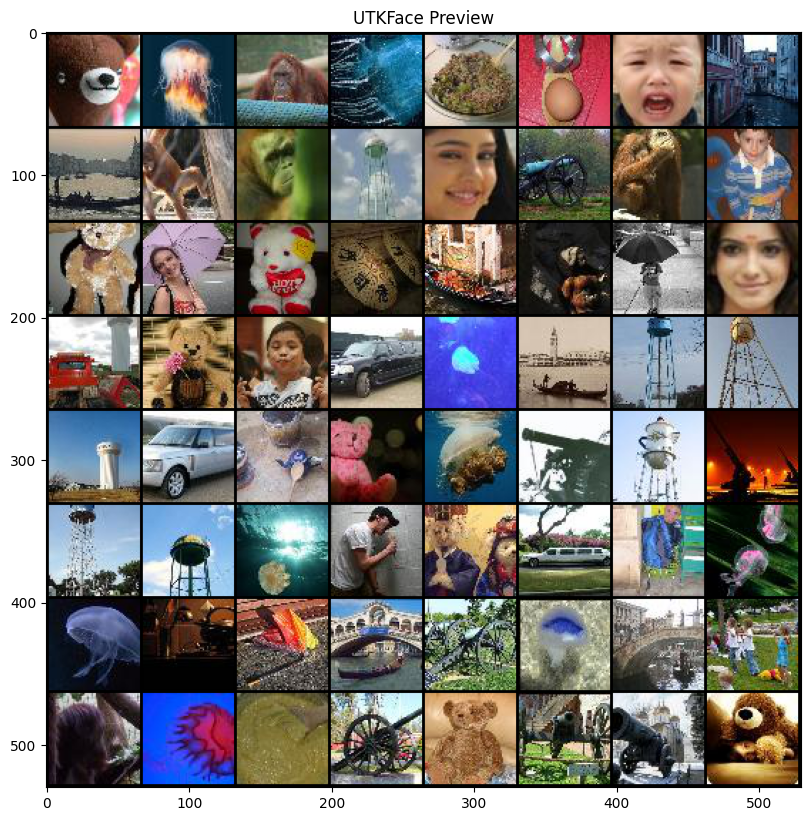

In [9]:
get_preview(dataloaders=utk_dataloaders, title="UTKFace Preview")

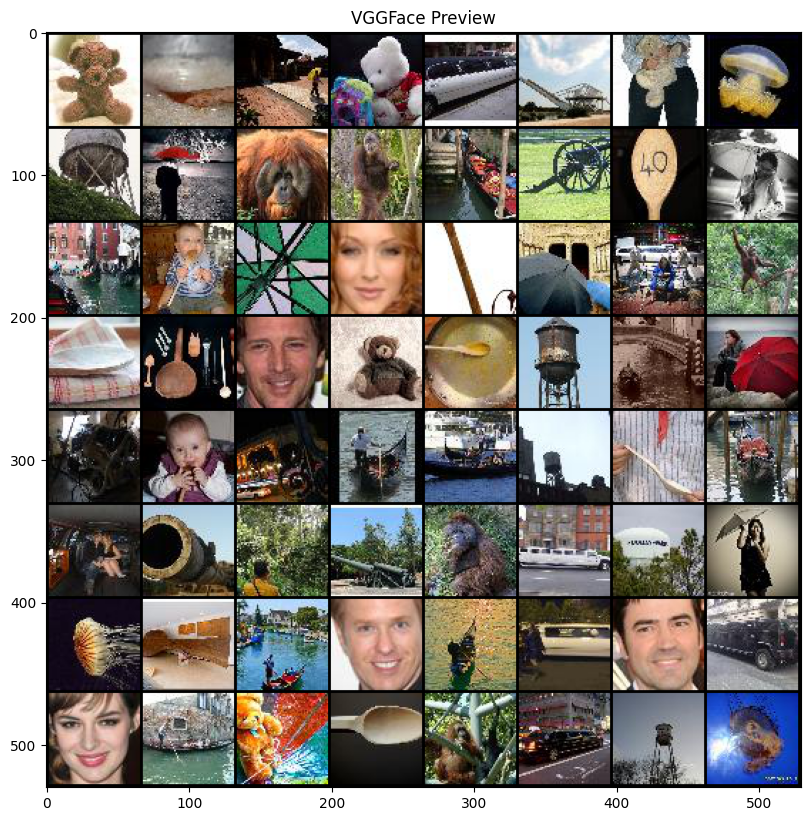

In [10]:
get_preview(dataloaders=vgg_dataloaders, title="VGGFace Preview")

## Model Training

In [11]:

# Parameters
EPOCH = 25
LEARNING_RATE = 0.001
SGD_MOMENTUM = 0.9
SGD_WEIGHT_DECAY = 0.0001
LR_DECAY_STEP_SIZE = 7
LR_DECAY_FACTOR = 0.1


def train_model(model_ft: Any, dataloaders, image_datasets, verbose=False):
    def _train_model(model: Any, criterion, optimizer, scheduler, dl, img_datasets):
        since = time.time()
        stats = []

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for epoch in range(EPOCH):
            stat = []
            if verbose:
                print('Epoch {}/{}'.format(epoch, EPOCH - 1))
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0  # Positive
                running_incorrect = 0  # Negative

                # Iterate over data.
                for imgs, labels in dl[phase]:
                    # print('Iterating ', labels, '...')
                    torch.cuda.empty_cache()  # clean up cache
                    # print(torch.cuda.memory_summary(device=device, abbreviated=False))
                    imgs = imgs.float().to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(imgs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * imgs.size(0)
                    running_corrects += torch.eq(preds, labels.data).sum()
                    running_incorrect += torch.not_equal(preds, labels.data).sum()

                    # print(running_loss, running_corrects)

                if phase == 'train':
                    scheduler.step()
                dataset_size = len(img_datasets[phase])
                epoch_loss = running_loss / dataset_size  # FN
                epoch_acc = running_corrects.double() / dataset_size  # TP
                epoch_tn = running_incorrect.double() / dataset_size  # TN

                # print(epoch_loss, epoch_acc)
                # print(epoch_tn)

                if verbose:
                    print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                        phase, epoch_loss, epoch_acc * 100))
                    print()
                stat.append(epoch_loss)
                stat.append(epoch_acc.item())
                # print('this is stat: ' + str(stat))
                # nb_classes = 2 #??
                # confusion_matrix = torch.zeros(nb_classes, nb_classes)
                # deep copy the model
                if phase == 'val':
                    # print(stats)
                    # inputs = inputs.to(device)
                    # classes = classes.to(device)
                    # outputs = model_ft
                    stats.append(stat)
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:2f}'.format(best_acc * 100))

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model, stats

    num_ftrs = model_ft.fc.in_features

    # TODO: Here the size of each output sample is set to 2 it is the number of classes.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, len(image_datasets['train'].get_class_names()))

    model_ft = model_ft.to(device)

    loss_fn = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, weight_decay=SGD_WEIGHT_DECAY,
                             momentum=SGD_MOMENTUM)

    # Decay LR by a factor of 0.1 every 7 epochs
    # TODO: Perhaps we can consider ReduceLROnPlateau instead
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=LR_DECAY_STEP_SIZE, gamma=LR_DECAY_FACTOR)

    return _train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                        dl=dataloaders, img_datasets=image_datasets)

# model_arch = models.resnet50()


In [12]:
imgnet_model_ft, imgnet_stats = train_model(models.resnet50(), dataloaders=imagenet_dataloaders,
                                            image_datasets=imagenet_datasets,
                                            verbose=True)


Epoch 0/24
----------
train Loss: 2.2287 Acc: 14.33%

val Loss: 2.9734 Acc: 18.89%

Epoch 1/24
----------
train Loss: 2.1318 Acc: 17.89%

val Loss: 2.1213 Acc: 19.11%

Epoch 2/24
----------
train Loss: 2.0410 Acc: 22.93%

val Loss: 1.9977 Acc: 22.22%

Epoch 3/24
----------
train Loss: 1.9742 Acc: 26.87%

val Loss: 1.9693 Acc: 23.56%

Epoch 4/24
----------
train Loss: 1.9220 Acc: 28.53%

val Loss: 1.8418 Acc: 29.11%

Epoch 5/24
----------
train Loss: 1.8707 Acc: 30.69%

val Loss: 1.8639 Acc: 30.00%

Epoch 6/24
----------
train Loss: 1.7891 Acc: 33.51%

val Loss: 1.8182 Acc: 33.33%

Epoch 7/24
----------
train Loss: 1.7280 Acc: 37.84%

val Loss: 1.7765 Acc: 33.33%

Epoch 8/24
----------
train Loss: 1.7032 Acc: 38.80%

val Loss: 1.7651 Acc: 33.78%

Epoch 9/24
----------
train Loss: 1.6998 Acc: 39.33%

val Loss: 1.7694 Acc: 33.11%

Epoch 10/24
----------
train Loss: 1.6709 Acc: 40.07%

val Loss: 1.7771 Acc: 33.33%

Epoch 11/24
----------
train Loss: 1.6620 Acc: 39.13%

val Loss: 1.7546 Acc

In [13]:
utk_model_ft, utk_stats = train_model(models.resnet50(), dataloaders=utk_dataloaders, image_datasets=utk_datasets,
                                      verbose=True)


Epoch 0/24
----------
train Loss: 2.3273 Acc: 13.30%

val Loss: 2.3469 Acc: 15.00%

Epoch 1/24
----------
train Loss: 2.2145 Acc: 18.02%

val Loss: 2.3488 Acc: 19.20%

Epoch 2/24
----------
train Loss: 2.1546 Acc: 21.86%

val Loss: 2.0474 Acc: 24.60%

Epoch 3/24
----------
train Loss: 2.0647 Acc: 25.28%

val Loss: 2.0523 Acc: 27.60%

Epoch 4/24
----------
train Loss: 1.9624 Acc: 29.88%

val Loss: 1.9332 Acc: 29.80%

Epoch 5/24
----------
train Loss: 1.8673 Acc: 31.64%

val Loss: 1.8847 Acc: 31.00%

Epoch 6/24
----------
train Loss: 1.7825 Acc: 36.44%

val Loss: 1.8577 Acc: 33.80%

Epoch 7/24
----------
train Loss: 1.6771 Acc: 41.30%

val Loss: 1.7795 Acc: 33.60%

Epoch 8/24
----------
train Loss: 1.6524 Acc: 42.16%

val Loss: 1.7718 Acc: 35.40%

Epoch 9/24
----------
train Loss: 1.6201 Acc: 43.48%

val Loss: 1.7483 Acc: 35.80%

Epoch 10/24
----------
train Loss: 1.5956 Acc: 44.84%

val Loss: 1.7510 Acc: 36.60%

Epoch 11/24
----------
train Loss: 1.5794 Acc: 46.18%

val Loss: 1.7340 Acc

In [ ]:
# To see if we can get the same accuracy
# utk_model_ft2, _ = train_model(models.resnet50(), dataloaders=utk_dataloaders, image_datasets=utk_datasets,
#                                verbose=True)

In [14]:
vgg_model_ft, vgg_stats = train_model(models.resnet50(), dataloaders=vgg_dataloaders, image_datasets=vgg_datasets,
                                      verbose=True)


Epoch 0/24
----------
train Loss: 2.3758 Acc: 12.12%

val Loss: 5.4075 Acc: 13.80%

Epoch 1/24
----------
train Loss: 2.2911 Acc: 16.72%

val Loss: 2.3450 Acc: 18.60%

Epoch 2/24
----------
train Loss: 2.1856 Acc: 20.08%

val Loss: 2.1103 Acc: 26.00%

Epoch 3/24
----------
train Loss: 2.0856 Acc: 25.80%

val Loss: 2.0057 Acc: 29.80%

Epoch 4/24
----------
train Loss: 1.9596 Acc: 30.80%

val Loss: 1.9742 Acc: 27.60%

Epoch 5/24
----------
train Loss: 1.8864 Acc: 32.92%

val Loss: 1.8571 Acc: 33.80%

Epoch 6/24
----------
train Loss: 1.7942 Acc: 36.32%

val Loss: 1.8168 Acc: 35.80%

Epoch 7/24
----------
train Loss: 1.6551 Acc: 41.30%

val Loss: 1.7367 Acc: 37.60%

Epoch 8/24
----------
train Loss: 1.6284 Acc: 43.54%

val Loss: 1.7315 Acc: 38.00%

Epoch 9/24
----------
train Loss: 1.6023 Acc: 44.72%

val Loss: 1.7278 Acc: 39.80%

Epoch 10/24
----------
train Loss: 1.5820 Acc: 45.30%

val Loss: 1.7314 Acc: 42.20%

Epoch 11/24
----------
train Loss: 1.5560 Acc: 46.16%

val Loss: 1.7097 Acc

In [15]:
# Save stats
def save_stats(s: List[List], file_n: str) -> None:
    with open(file_n, "w", encoding="utf-8") as f:
        for elem in s:
            f.write("%s,%s,%s,%s\n" % (elem[0], elem[1], elem[2], elem[3]))


save_stats(imgnet_stats, "imgnet_stats.csv")
save_stats(utk_stats, "utk_stats.csv")
save_stats(vgg_stats, "vgg_stats.csv")


## Model Visualization

In [16]:
def visualize_model(model, datasets: dict, dataloaders: dict, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(10, 15), dpi=100)

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dataloaders['val']):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for j in range(imgs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                pred_str = datasets["train"].get_class_name(preds[j].item()).split(",")[0]
                gt_str = datasets["train"].get_class_name(labels.cpu().numpy()[images_so_far - 1]).split(",")[0]
                ax.set_title(('Pred:%s   GT:%s' % (pred_str, gt_str)))
                image_show(imgs.int().cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

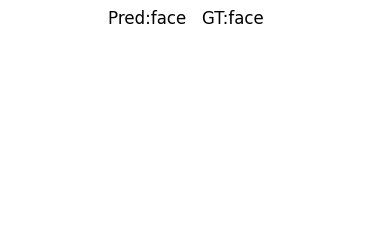

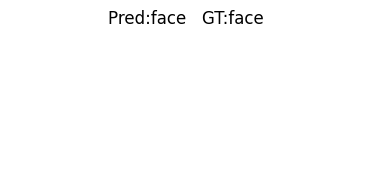

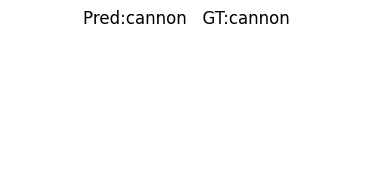

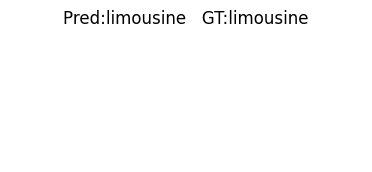

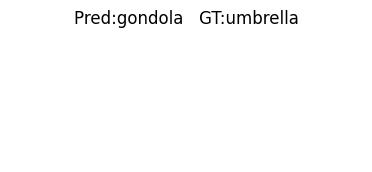

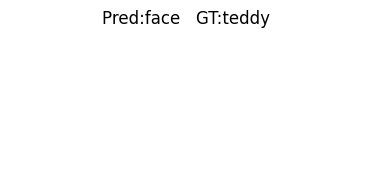

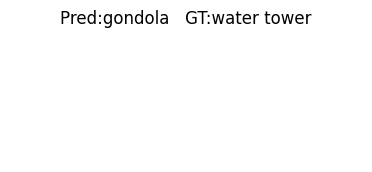

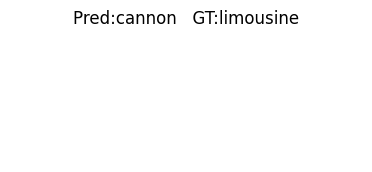

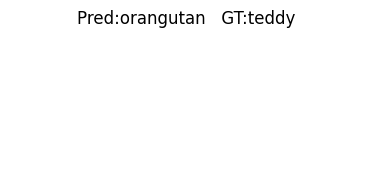

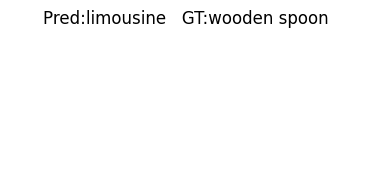

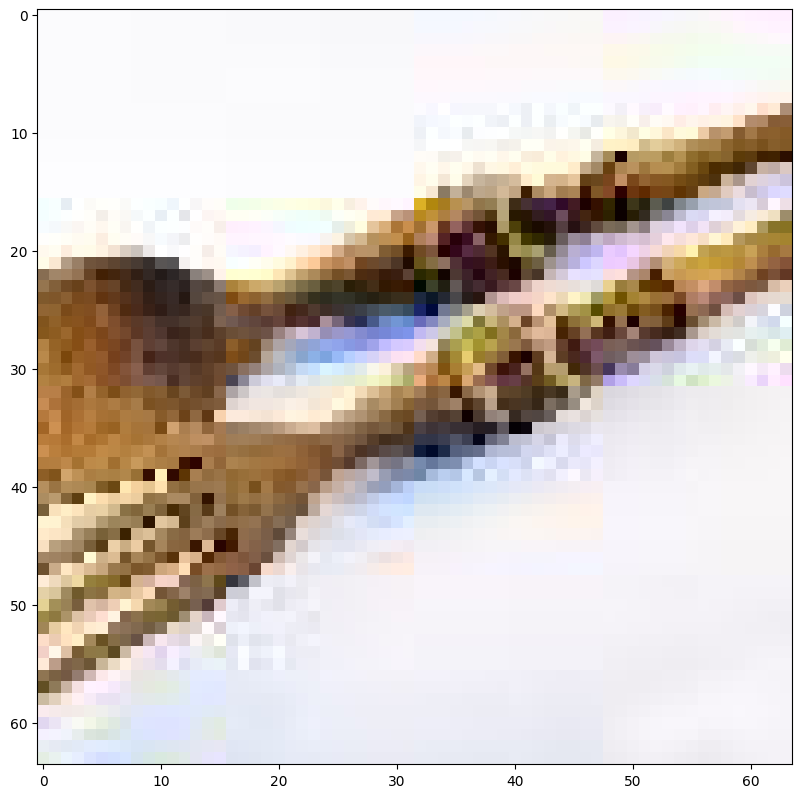

In [17]:
# Visualize utk models
visualize_model(utk_model_ft, utk_datasets, utk_dataloaders)

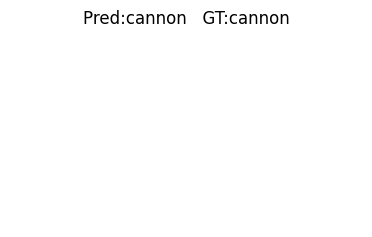

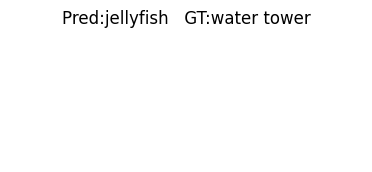

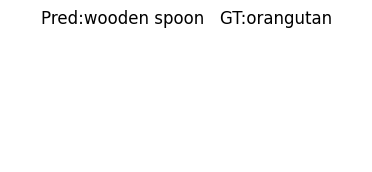

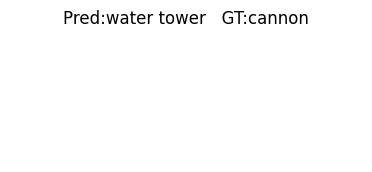

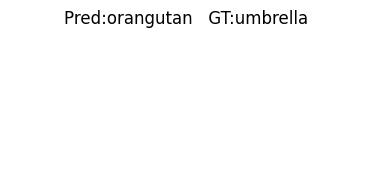

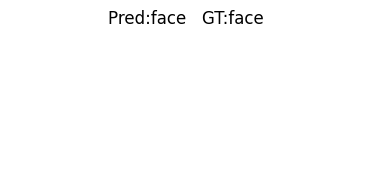

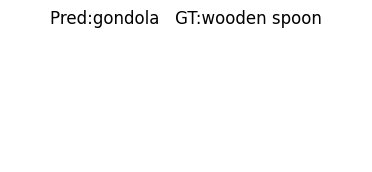

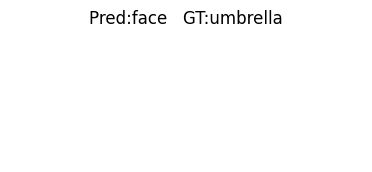

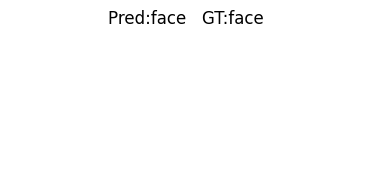

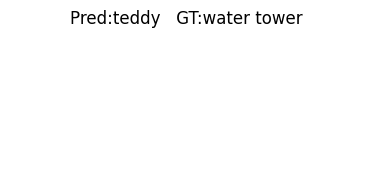

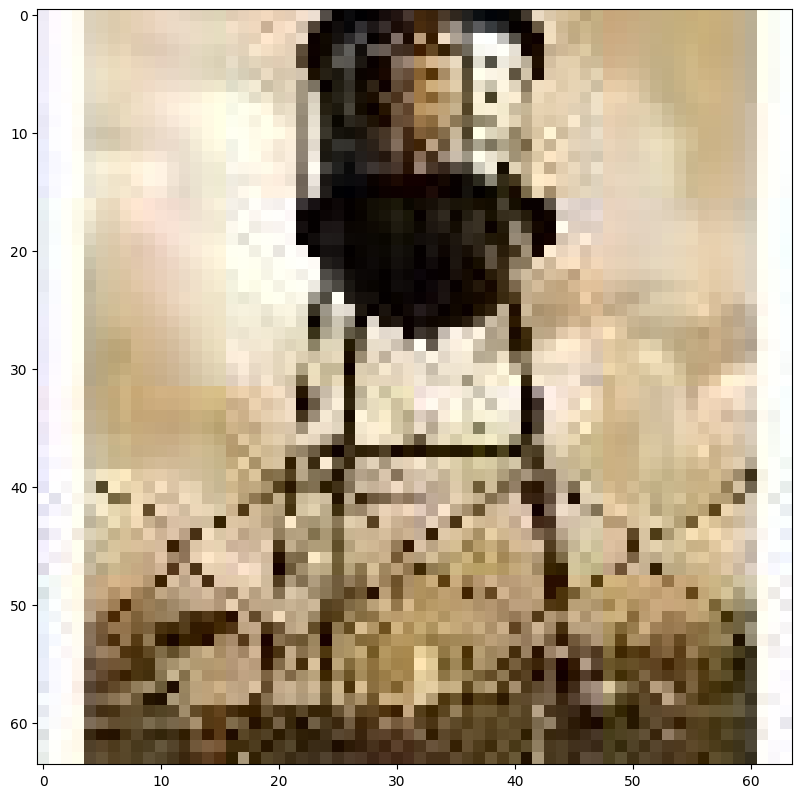

In [18]:
# Visualize vgg models
visualize_model(vgg_model_ft, vgg_datasets, vgg_dataloaders)

In [19]:
# make predictions for utk_vgg dataset
def model_prediction(model):
    was_training = model.training
    correct = 0
    total = 0
    model.eval()
    # Disable gradient calculation

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(utk_vgg_dataloader):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

    for i in range(preds.size()[0]):
        total += 1
        if preds[i].item() == utk_vgg_dataset[i][1]:
            correct += 1
    print('total: ', total)
    print('correct: ', correct)
    print('accuracy: ', (correct / total))
    model.train(mode=was_training)

In [20]:
model_prediction(utk_model_ft)

total:  100
correct:  81
accuracy:  0.81


In [21]:
model_prediction(vgg_model_ft)

total:  100
correct:  82
accuracy:  0.82


# ROC Curve

In [ ]:
def _plot_roc_curve(val, preds):
    fpr, tpr, _ = roc_curve(val, preds)

    plt.figure(1, figsize=(6, 5))
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.plot(fpr, tpr, color='darkorange')
    plt.legend(loc="lower right")
    plt.show()


# test array
valid = np.array([1, 1, 0, 0])
val_scores = np.array([0.1, 0.4, 0.35, 0.8])

plot = _plot_roc_curve(valid, val_scores)